# Legal Intelligence Rank Monitor


<br>



This jupyter notebook provides the prototype of the rank monitor:

It should:

- Request queries, clicks and their corresponding position on the query list
- Pre-process the data into readable format
- Calculate the NDCG
- Be able to re-run queries, with appropriate access rights and re-calculate the nDCG

<br> 


### Basic Utilities for python

In [7]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os

import datetime
from datetimerange import DateTimeRange
from datetime import timedelta  
from dateutil import parser
from urllib import *
import json

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from collections import Counter
from tqdm import tqdm_notebook 
tqdm_notebook().pandas()
from tqdm import tqdm_notebook as tqdm

from time import strftime, gmtime
import pathlib

import requests
import urllib

import re
import glob
import time 

# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 8)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [8]:
# Activate Jupyter %%javascript magic
%lsmagic


Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

### Javascript for a duplicate line on Ctrl-P
Run this to set a keyboard shortcut do duplicate a line on: Control+P

In [9]:
%%js

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('Ctrl-p', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();
        
        // read a content from a line where is the current cursor
        
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

### DCG function

Implementation for the discounted cumulative gain (DCG) function.


$$ \mathrm{DCG_{p}} = \sum_{i=1}^{N} \frac{rel_{i}}{\log_{b}(i+1)} = rel_1 + \sum_{i=2}^{N} \frac{rel_{i}}{\log_{b}(i+1)} \text{for b} = 2  $$

Mean average precision (MAP) |

$$ F_{1}=\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$  

F1 score (only defined for binary relevance scores).

$$ \operatorname{MAP} = \frac{\sum_{q=1}^N \operatorname{AveP(q)}}{N} $$ 


<br> 




In [10]:
# y_true = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0])
# print(y_true.shape)
# y_true_2 = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0,1])


def dcg(y_true: np.array, log_base: 2):
    """
    Returns ndcg given the truth values (clicks) for a given query
    :param y_true: np.array of clicked documents in order
    :param log_base: the log discount factor
    :return:
    """
    gain = y_true[0]
    for index, rel_i in enumerate(y_true):
        if index !=0:
            gain += rel_i / (math.log(rel_i+index+1, log_base))
    return gain


In [11]:
def list_currentdir():
    """
    Helper function to print contents of current directory and /data/ dir.
    """
    currentdir = Path('./data/')
    display([file for file in currentdir.glob('*')])
    display([file for file in Path('./').glob('*')])
    display([file for file in Path('./multiple_query/').glob('*')])


list_currentdir()


[PosixPath('data/EventID:232_all_120000_to_170000'),
 PosixPath('data/df_232'),
 PosixPath('data/df_27'),
 PosixPath('data/EventID:232_all_50000_to_80000'),
 PosixPath('data/Queries Rank Monitor.xlsx'),
 PosixPath('data/EventID:232_all_130000_to_170000'),
 PosixPath('data/EventID:232_all_80000_to_130000'),
 PosixPath('data/EventID:232_all_80000_to_120000'),
 PosixPath('data/EventID:232_0_to_50000')]

[PosixPath('rank_monitor.ipynb'),
 PosixPath('data'),
 PosixPath('all_curl'),
 PosixPath('queries_multiple_times.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('text_files'),
 PosixPath('response_example.json'),
 PosixPath('.git'),
 PosixPath('dcg_plot'),
 PosixPath('query_count_histogram'),
 PosixPath('README.md'),
 PosixPath('Precision_plot'),
 PosixPath('old'),
 PosixPath('plots'),
 PosixPath('curl'),
 PosixPath('.interactive_notebook.ipynb.swo'),
 PosixPath('Untitled1.ipynb'),
 PosixPath('plots.jpeg'),
 PosixPath('data_rank'),
 PosixPath('rank_monitor-dataframe232.ipynb'),
 PosixPath('Untitled.ipynb'),
 PosixPath('.interactive_notebook.ipynb.swp')]

[]

# Dynamic ranking

<br>


In [12]:
def request_into_dataframe(rows= 100, query= '*:*', sort='') -> pd.DataFrame :
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    response = requests.get(url)

    # Transform the request into a json
    response = response.json()
    response = response['response']['docs'][1:]

    df =  pd.DataFrame(response)
    
    return df
    
    

In [13]:
def get_dataframe_232(rows=100000000, from_disk=False, save_name='df_232') -> pd.DataFrame:
    """
    Get all the logging with a clicked documentPosition. 
    DocumentPosition clicked is logged since 01-07-2019 -> 20190701
    :param rows: query 
    :param from_disk: query string
    :param save_name: query string
    :return:
    """
    
    directory = './data/{}'.format(save_name)

    
    if from_disk:
        return pd.read_hdf(directory)
    else:
        df_232 = request_into_dataframe(rows=rows, query='EventID:232 & sort=ShortTimeStamp desc')
        
        # Get query of reponsehader into a seperate column. 
        df_232['SearchText'] = df_232['ResponseHeader'].progress_apply(lambda x: json.loads(x)['params']['userQuery'][:])
    
        #   Transform documentIDs from string to list of strings. 
        df['DocumentIDs'] = df['DocumentIDs'].progress_apply(lambda x: str(x).split())    

        if not os.path.exists(directory):
            os.makedirs(directory)
    
        df_232.to_hdf(directory, key='test', mode='w')
        
    return df_232 


def get_dataframe_27(rows=100000000, from_disk=False, save_name='df_27') -> pd.DataFrame:
    """
    Get all the logging with a clicked documentPosition. 
    DocumentPosition clicked is logged since 01-07-2019 -> 20190701
    :param rows: query 
    :param from_disk: query string
    :param save_name: query string
    :return:
    """
      
    directory = './data/{}'.format(save_name)
        
    if from_disk:
        return pd.read_hdf(directory)
    
    else:
        print("Requesting dataframe 27")
        df_27 = request_into_dataframe(rows=rows, query='EventID:27 AND ShortTimeStamp:[20190701 TO 20201201]')
        df_27.to_hdf(directory, key='test', mode='w')
        print("Retrieved dataframe 27")

    return df_27 




# Aggregating Clicks to user sessions

<br>

In [14]:
def check_in_timerange(df_232_group = pd.DataFrame, df_27 = pd.DataFrame) -> list:
    """
    Check if the there are clickedobjects within + and - 5 minutes from the query
    timestamp: object from the dateutil parser library
    :param timestamp:
    :param query:
    :param df_27:
    """
    
    timestamps_27 = [parser.parse(time, fuzzy_with_tokens=False) for time in df_27['TimeStamp'].tolist()]    
    stamp_232 = parser.parse(df_232_group['TimeStamp'].iloc[0], fuzzy_with_tokens=False)
    
    doc_pos = []
    doc_ids = []
    
    for idx, stamp_27 in enumerate(timestamps_27):        
        if (stamp_27 in DateTimeRange(stamp_232, stamp_232  + timedelta(minutes=5))):

            doc_pos.append(df_27['DocumentPosition'].iloc[idx])
            doc_ids.append(df_27['DocumentID'].iloc[idx])

    return doc_pos, doc_ids


def check_and_concat(df_232: pd.DataFrame, df_27: pd.DataFrame) -> pd.DataFrame:
    """
    Check both dataframes get clicks from 27 and add these to responseheader taken from 232
    :param df_232: dataframe containing the 232 log
    :param df_27: dataframe containing the 27 log
    """
    
    final_pos = [] 
    final_ids = []
    
    for idx, (df_shape, df_232_groupby) in enumerate(tqdm(df_232.groupby(by=['UserID','ShortTimeStamp','ID']) , desc='Looping through queries')):
        
        # Ony check searches 27 from the specific user on specific day. 
#         temp_27 = df_27[(df_27['UserID'] == df_232_groupby['UserID'].iloc[0]) & (df_27['ShortTimeStamp'] == df_232_groupby['ShortTimeStamp'].iloc[0])
#                        & (df_27['SearchText'] == df_232_groupby['SearchText'].iloc[0])]

        temp_27 = df_27[(df_27['UserID'] == df_232_groupby['UserID'].iloc[0]) & (df_27['SearchText'] == df_232_groupby['SearchText'].iloc[0])]
    
        doc_pos = []
        doc_ids = []
        
        if not temp_27.empty:
            doc_pos, doc_ids = check_in_timerange(df_232_groupby, temp_27)
#             doc_pos.extend(temp_27['DocumentPosition'].tolist())
#             doc_ids.extend(temp_27['DocumentID'].tolist())
            final_pos.append(doc_pos)
            final_ids.append(doc_ids)
        else:
            # No clicks found
            final_pos.append([])
            final_ids.append([])

            
    # Get the ordering we found from the GroupBy ordering from the for loop above
    df_232 = df_232.sort_values(by=['UserID','ShortTimeStamp','ID'])

    df_232['ClickedPos'] = final_pos
    df_232['ClickedIDs'] = final_ids
        
    return df_232


In [15]:
def make_predictions(df: pd.DataFrame) -> []:
    """
    Transforms document positions to a vector of zeros and ones
    From [1,4] --> [1,0,0,1]
    :param dataframe: pd.DataFrame of pd.Series that contains a DocumentPosition column 
    :return: list of predictions
    """
    predictions = []
    for val in df['ClickedPos']:
        maximum = np.max(val) 
        y_pred = np.zeros(shape=int(maximum)+1,)
        y_pred[val] = 1
        predictions.append(y_pred)
    return predictions
    

def calculate_ndcg(predictions: list, rank_at_k= 70, log_base= 2) -> []:
    """
    Given a list of predictions calculate the average DCG score per rank
    :param predictions: list of binary predictions e.g. [1,0,1,0,0,0,1]
    :param rank_at_k: range of the predictions 
    :param log_base: range of the predictions 
    :return: list of predictions
    """
    average_at_k = []
    for k in tqdm(range(1, rank_at_k), desc= "Calculating nDCG"):
        ndcgs = [] 
        for pred in predictions:
            ndcgs.append(dcg(pred[0:k], log_base))
        ave = np.average(ndcgs)
        average_at_k.append(ave)
    
    return average_at_k


def calculate_average_precision(predictions: list, rank_at_k= 70) -> []: 
    """
    Given a list of predictions calculate the average DCG score per rank
    :param predictions: list of binary predictions e.g. [1,0,1,0,0,0,1]
    :param rank_at_k: range of the predictions 
    :param log_base: range of the predictions 
    :return: list of predictions
    """
    average_at_k = []
    for k in tqdm(range(1, rank_at_k), desc= "Calculating average precision"):
        precisions = [] 
        for pred in predictions:
#             precisions.append(average_precision_custom(pred[0:k]))
            precisions.append(average_precision_score(pred[0:k], np.array([1] *  len(pred[0:k]))))
        ave = np.average(precisions)
        average_at_k.append(ave)
    
    return average_at_k

def plot_dcg_curve(average_at_k: []) -> plt.plot:
    """
    Plots the dcg curve per rank
    :param average_at_k:  
    """
    plt.plot(average_at_k)
    plt.xlabel('Rank k')
    plt.ylabel('DCG')
    plt.title("DCG at K")
    return plt


# Start aggregation

<br>

In [16]:
def main() -> pd.DataFrame:
    """
    Start the workflow:
    1. Download the required dataframe, aggregated the proper clicks together calculate a dcg score 
    Return DataFrame
    """
    
    df_27 = get_dataframe_27(rows=100000000, from_disk=True)
    df_232 = get_dataframe_232(rows=1000, from_disk=True )


    df = check_and_concat(df_232=df_232, df_27=df_27)
    
#   Cast documentids to a a new DocumentIDLength column
    df['DocumentIDLength'] = df['DocumentIDs'].str.split().str.len()
    
#   Remove clicks where nans were added
    df['ClickedPos'] = df['ClickedPos'].progress_apply(lambda x: [int(click) for click in x if not np.isnan(click)])

#   Remove empty click list 
    df = df[df['ClickedPos'].str.len() != 0]

#   TODO: Check if this works 
    df = df.dropna(axis=0,subset=['DocumentIDs', 'ClickedPos'])


    display(df)
    
    
    return df


df = main()
df


HBox(children=(IntProgress(value=0, description='Looping through queries', max=999, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, max=999), HTML(value='')))

,AppID,CompID,Department,DocumentIDs,EventID,FunctionArea,ID,Month,Quarter,ResponseHeader,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,SearchText,ClickedPos,ClickedIDs,DocumentIDLength
206,1,35,PG van der Wiel [PG039],13556760 13345129 31417267 32235097 13564922 1...,232,NaN,2177131e-0468-4ea8-bda2-4c2051e5a253,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T03:17:42.893Z,1369,546,29,2019,1639273962297884672,roquette frères,"[1, 4, 5, 6]","[13556760, 32235097, 13564922, 13564939]",20.0
25,1,123,Ondernemingsrecht Nijmegen,23457746 20044851 30855495 16386666 25686440 3...,232,NaN,1f4a4a13-1add-47ba-bd47-0e6a76c58241,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T00:21:41.882Z,375,4715,29,2019,1639262895251390464,executeur ruimschoots,[2],[20044851],20.0
603,1,670,Den Haag,31841674 31867092 31606193 25702877 31172173 3...,232,Personen- en Familierecht,9f513e81-843a-4029-8449-7af0ceb16ec5,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T23:00:04.629Z,1120,30982,29,2019,1639257760564510720,eenmanszaak echtscheiding schulden,[59],[30461864],20.0
693,1,670,Den Haag,31875299 31948137 31073162 22124815 31624746 2...,232,Personen- en Familierecht,fd897465-d4b9-4191-bb9e-5b8408d89020,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T22:56:40.934Z,1120,30982,29,2019,1639257552894033922,eenmanszaak echtscheiding schulden,[59],[30461864],20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,562,NaN,32091877 32108209 31667015 31581511 32143436 3...,232,NaN,c6f416bc-9493-4df8-b06f-459f03a2129f,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T01:18:18.795Z,3148,222150,29,2019,1639266462111629312,IPR contracten,[57],[14113971],20.0
88,1,562,NaN,24280647 24280642 23215049 23215047 23215053 2...,232,NaN,c799534d-2466-459d-aa79-1cbef3e4e326,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:22:09.924Z,406,222150,29,2019,1639266679049420800,TCR,"[41, 52]","[24280647, 22760819]",20.0
410,1,562,NaN,6179063 26949631 32219408 14122163 23719418 31...,232,NaN,f54c2fd6-e600-4147-a655-f20bd2a87571,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:31:42.687Z,582,222150,29,2019,1639267298892054528,Anglo-amerikaans recht,[4],[14122163],20.0
422,1,562,NaN,31410749 17752311 16237053 32250733 32279002 3...,232,NaN,fde02489-0a1e-409c-9328-4beb32790387,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T01:37:39.502Z,536,222150,29,2019,1639267653788893184,fiduciary duties,[2],[17752311],20.0


,AppID,CompID,Department,DocumentIDs,EventID,FunctionArea,ID,Month,Quarter,ResponseHeader,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,SearchText,ClickedPos,ClickedIDs,DocumentIDLength
206,1,35,PG van der Wiel [PG039],13556760 13345129 31417267 32235097 13564922 1...,232,NaN,2177131e-0468-4ea8-bda2-4c2051e5a253,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T03:17:42.893Z,1369,546,29,2019,1639273962297884672,roquette frères,"[1, 4, 5, 6]","[13556760, 32235097, 13564922, 13564939]",20.0
25,1,123,Ondernemingsrecht Nijmegen,23457746 20044851 30855495 16386666 25686440 3...,232,NaN,1f4a4a13-1add-47ba-bd47-0e6a76c58241,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T00:21:41.882Z,375,4715,29,2019,1639262895251390464,executeur ruimschoots,[2],[20044851],20.0
603,1,670,Den Haag,31841674 31867092 31606193 25702877 31172173 3...,232,Personen- en Familierecht,9f513e81-843a-4029-8449-7af0ceb16ec5,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T23:00:04.629Z,1120,30982,29,2019,1639257760564510720,eenmanszaak echtscheiding schulden,[59],[30461864],20.0
693,1,670,Den Haag,31875299 31948137 31073162 22124815 31624746 2...,232,Personen- en Familierecht,fd897465-d4b9-4191-bb9e-5b8408d89020,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T22:56:40.934Z,1120,30982,29,2019,1639257552894033922,eenmanszaak echtscheiding schulden,[59],[30461864],20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,562,NaN,32091877 32108209 31667015 31581511 32143436 3...,232,NaN,c6f416bc-9493-4df8-b06f-459f03a2129f,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T01:18:18.795Z,3148,222150,29,2019,1639266462111629312,IPR contracten,[57],[14113971],20.0
88,1,562,NaN,24280647 24280642 23215049 23215047 23215053 2...,232,NaN,c799534d-2466-459d-aa79-1cbef3e4e326,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:22:09.924Z,406,222150,29,2019,1639266679049420800,TCR,"[41, 52]","[24280647, 22760819]",20.0
410,1,562,NaN,6179063 26949631 32219408 14122163 23719418 31...,232,NaN,f54c2fd6-e600-4147-a655-f20bd2a87571,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:31:42.687Z,582,222150,29,2019,1639267298892054528,Anglo-amerikaans recht,[4],[14122163],20.0
422,1,562,NaN,31410749 17752311 16237053 32250733 32279002 3...,232,NaN,fde02489-0a1e-409c-9328-4beb32790387,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T01:37:39.502Z,536,222150,29,2019,1639267653788893184,fiduciary duties,[2],[17752311],20.0


In [12]:
def plot_dcg_curve(df):
    """
    Plot dcg curves from clicks
    :param df: dataframe returned from main function
    """ 
    
    predictions_1 = make_predictions(df)
    predictions_2 = make_predictions(df[df['SearchText'].str.split().apply(len) >= 3] )
    predictions_3 = make_predictions(df[df['SearchText'].str.split().apply(len) == 1] )

    average_at_k_1  =  calculate_ndcg(predictions_1, 100)
    average_at_k_2 =  calculate_ndcg(predictions_2, 100)
    average_at_k_3 =  calculate_ndcg(predictions_3, 100)

    plt.plot(average_at_k_1,   label= 'Average DCG for all user sessions')
    plt.plot(average_at_k_2, label= 'DCG for queries larger than 3 word')
    plt.plot(average_at_k_3, label= 'DCG for single-word queries')
    plt.legend()

    plt.xlabel('Rank k')
    plt.ylabel('DCG')
    plt.title("DCG at K")
    plt.show()

In [13]:
def plot_dcg_curve(df):
    """
    :param df: 
    """
    predictions = make_predictions(df)

    df_3 = df_3 = df[df['SearchText'].str.split().apply(len) >= 3] 
    predictions_3 = make_predictions(df_3)


    df_4 = df[df['SearchText'].str.split().apply(len) == 1] 
    predictions_4 = make_predictions(df_4)

    average_at_k   =  calculate_ndcg(predictions, 100, log_base=10)
    average_at_k_3 =  calculate_ndcg(predictions_3, 100, log_base=10)
    average_at_k_4 =  calculate_ndcg(predictions_4, 100, log_base=10)


    plt.plot(average_at_k,   label= 'Average DCG for all user sessions')
    plt.plot(average_at_k_3, label= 'DCG for queries larger than 3 word')
    plt.plot(average_at_k_4, label= 'DCG for single-word queries')

    plt.legend()

    plt.xlabel('Rank k')
    plt.ylabel('DCG')
    plt.title("DCG at K")

    plt.savefig('./dcg_plot', format='svg', dpi=1200)
    plt.show()

NameError: name 'df' is not defined

HBox(children=(IntProgress(value=0, max=4999), HTML(value='')))

(array([2024., 1370.,  808.,  361.,  182.,  134.,   66.,   18.,   10.,
           8.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

Text(0.5,0,'Query length')

Text(0,0.5,'Raw count')

Text(0.5,1,'Histogram of query count')

No handles with labels found to put in legend.


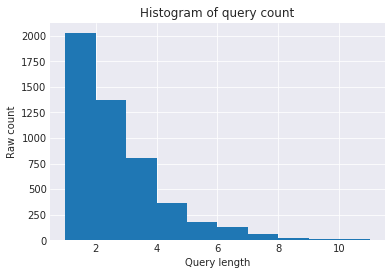

In [14]:
def histogram_query_coutn():
    """
    Plot histogram query count
    
    """
    df = get_dataframe_232(rows=5000, from_disk=True)
    df['QueryWordLength'] = df['SearchText'].str.split().str.len()

    df['QueryWordLength'] = df['QueryWordLength'].progress_apply(lambda x: int(x))

    df = df[df['QueryWordLength'] <= 11 ] 

    plt.hist(df['QueryWordLength'] )
    plt.xlabel('Query length')
    plt.ylabel('Raw count')
    plt.title('Histogram of query count')
    plt.legend()
    plt.savefig('./query_count_histogram', format='jpeg', dpi=1200)
    plt.show()

HBox(children=(IntProgress(value=0, description='Calculating average precision', max=99), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


HBox(children=(IntProgress(value=0, description='Calculating average precision', max=99), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Calculating average precision', max=99), HTML(value='')))

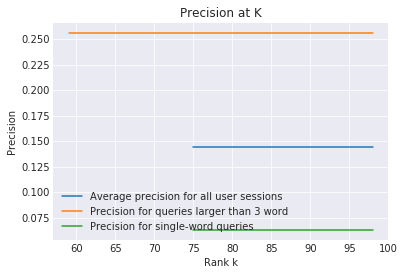

In [60]:
def average_precision_plot(df: pd.DataFrame):

    predictions = make_predictions(df)

    df_2 = df_2 = df[df['SearchText'].str.split().apply(len) >= 3] 
    predictions_2 = make_predictions(df_2)


    df_3 = df[df['SearchText'].str.split().apply(len) == 1] 
    predictions_3 = make_predictions(df_3)

    average_at_k   =  calculate_average_precision(predictions, 100)
    average_at_k_2 =  calculate_average_precision(predictions_2, 100)
    average_at_k_3 =  calculate_average_precision(predictions_3, 100)

    plt.plot(average_at_k,   label= 'Average precision for all user sessions')
    plt.plot(average_at_k_2, label= 'Precision for queries larger than 3 word')
    plt.plot(average_at_k_3, label= 'Precision for single-word queries')

    plt.legend()
    
    plt.xlabel('Rank k')
    plt.ylabel('Precision')
    plt.title("Precision at K")

    plt.savefig('./Precision_plot', format='svg', dpi=1200)
    plt.show()
    
average_precision_plot(df)

In [17]:
import json
import urllib

df = get_dataframe_232(rows=1000, from_disk=True)

def query_replication(df: pd.DataFrame):
    """
    Helper function to replicate queries
    :param df: dataframe containing a ResponseHeader from solr
    """   
    # Comment out to not display the original response
#     display(x)
#     display(df)
    for i in range(len(df)):
        df_locked = df.iloc[i]
        x = json.loads(df_locked['ResponseHeader'])
        x = x['params']

        # Disable these boosting factors
        x['legislationQ'] = ''
        x['legislationBoostQ'] = ''
        x['lowRankQ'] = ''
        x['newsQ'] = ''
        
        new_query = []
        for key,value in x.items():
            if key == 'fq':
                for fq_value in value:
                    fq_value = urllib.parse.quote(string=str(fq_value))
                    new_query.append("&{}={}".format('fq',fq_value))

            elif key == 'shards':
                value = value.replace("PRD_","ACC_")
                value = urllib.parse.quote(string=str(value))
                new_query.append("&{}={}".format(key,value))
            elif key == 'json.facet':
                pass
            else:
                value = urllib.parse.quote(string=str(value))
                new_query.append("&{}={}".format(key,value))


        params = ''.join(new_query)

        # Comment out to not display the newly made query
#         display(new_query)
        directory = "./all_curl/"

        if not os.path.exists(directory):
            os.makedirs(directory)

        pathlib.Path(directory + 'param_{}.txt'.format(i)).write_text(params)

    
query_replication(df)


In [14]:
import json
import urllib

# df = get_dataframe_232(rows=100, from_disk=True)
# df

"""
Helper function to replicate queries
:param df: dataframe containing a ResponseHeader from solr
"""
df
i = 3
# df = df.iloc[i]
x = json.loads(df.iloc[0]['ResponseHeader'])
x = x['params']

# #  Disable these boosting factors
# x
# x['legislationQ'] = "ID:0" 
# x['expiredQ'] = "ID:0" 
# x['legislationBoostQ']=  "ID:0" 
# x

new_query = []
for key,value in x.items():
    if key == 'fq':
        for fq_value in value:
            fq_value = urllib.parse.quote(string=str(fq_value))
            new_query.append("&{}={}".format('fq',fq_value))
    elif key == 'shards':
        value = value.replace("PRD_","ACC_")
        value = urllib.parse.quote(string=str(value))
        new_query.append("&{}={}".format(key,value))
    elif key == 'json.facet':
        pass
    else:
        value = urllib.parse.quote(string=str(value))
        new_query.append("&{}={}".format(key,value))


params = ''.join(new_query)

directory=  './curl/'

pathlib.Path(directory  + 'params.txt').write_text(params)




'\nHelper function to replicate queries\n:param df: dataframe containing a ResponseHeader from solr\n'

NameError: name 'df' is not defined

# Read in response
<br>


In [63]:
path = Path('./')
[x for x in path.glob('*')]


import json


# df_232 = get_dataframe_232(rows=1000, from_disk=True)


with open('./response_example.json') as json_file:
    data = json.load(json_file)

[x for x in data.keys()]


def read_json(files=[]):
    """
    
    :param files:
    """

    all_ids = []
    all_pos = []
    all_scores = [] 
    
    for file_name in files:
        docids = []
        positions = []
        scores = []
    
        with open(file_name) as json_file:
            data = json.load(json_file)
#             display(data)
        for idx,document in enumerate(data['response']['docs']):
            docids.append(document['ID'])
            positions.append(idx)
            scores.append(document['score'])
        
#         data
        all_ids.append(docids)
        all_pos.append(positions)
        all_scores.append(scores)
        query = data['responseHeader']['params']['userQuery']
        display(query)
    return all_ids, all_pos, all_scores
       
    
    
df
    
# # all_ids, all_pos, all_scores = read_json(['./response_example.json'])
# all_ids, all_pos, all_scores = read_json(['./curl/response.json'])

# all_pos
# all_ids   
# df.iloc[0]['DocumentIDs']
# df
                              
# read_json(['./response_example.json'])

# responses = len(data['response']['docs'])
# response


# docids = []
# positions = []
# scores = []
# # parse all docs 
# for idx,document in enumerate(data['response']['docs']):
#     docids.append(document['ID'])
#     positions.append(idx)
#     scores.append(document['score'])

# # docids
# scores
    

[PosixPath('rank_monitor.ipynb'),
 PosixPath('data'),
 PosixPath('all_curl'),
 PosixPath('queries_multiple_times.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('text_files'),
 PosixPath('response_example.json'),
 PosixPath('.git'),
 PosixPath('dcg_plot'),
 PosixPath('query_count_histogram'),
 PosixPath('README.md'),
 PosixPath('Precision_plot'),
 PosixPath('old'),
 PosixPath('plots'),
 PosixPath('curl'),
 PosixPath('.interactive_notebook.ipynb.swo'),
 PosixPath('plots.jpeg'),
 PosixPath('data_rank'),
 PosixPath('rank_monitor-dataframe232.ipynb'),
 PosixPath('Untitled.ipynb'),
 PosixPath('.interactive_notebook.ipynb.swp')]

['responseHeader', 'response', 'facet_counts', 'expanded']

,AppID,CompID,Department,DocumentIDs,EventID,FunctionArea,ID,Month,Quarter,ResponseHeader,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,SearchText
0,1,1238,NaN,1741272,232,NaN,18e85792-4b7d-493a-85dc-51c721e39a03,7,3,"{""li.ext"":[[""li.queryterms"",[[""DOCREF"",[[[""ID""...",20190717,1,2019-07-17T00:05:46.887Z,1,99820,29,2019,1639261896432418816,wahv betali gsregeling
1,1,1238,NaN,32253077 32022069 32257047 32246841 32258612 3...,232,NaN,5eabdf58-e099-433a-8cff-f2cd1592af66,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T00:05:56.323Z,19354,99820,29,2019,1639261896447098880,Betalingsregeling
2,1,1238,NaN,32126661 32121149 32121193 32081875 32081848 3...,232,NaN,04f36ef7-d1f0-4fe3-9279-5638ed3a530e,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T00:06:08.575Z,489,99820,29,2019,1639261896453390336,Betalingsregeling wahv
3,1,1470,NaN,32248840 32247373 32240037 32234574 31799416 3...,232,NaN,ff000846-a4ce-408e-982f-52326493741e,7,3,"{""li.ext"":[[""li.queryterms"",[[""NUMBER"",[[[""ter...",20190717,1,2019-07-17T00:06:12.419Z,3934615,148468,29,2019,1639261900423299072,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1245,Wetenschappelijke ondersteuning,32253772 32284934 32101971 30716951 30826117 3...,232,NaN,d5f288de-cb20-41c6-9cba-523f51841a18,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T06:05:26.728Z,35447,231807,29,2019,1639284502076325888,Aansprakelijkheidsrecht
996,1,1245,Wetenschappelijke ondersteuning,32253772 32284934 32101971 30716951 30826117 3...,232,NaN,c76d1bbe-5122-467e-bb0c-11e3cf8b6fe4,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T06:05:27.117Z,35447,152683,29,2019,1639284502164406272,Aansprakelijkheidsrecht
997,1,1245,Wetenschappelijke ondersteuning,32253772 32284934 32101971 30716951 30826117 3...,232,NaN,a8ca6e1e-9ca8-4995-a69b-40e80f30c989,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T06:05:27.610Z,35447,233697,29,2019,1639284502681354240,Aansprakelijkheidsrecht
998,1,1245,Wetenschappelijke ondersteuning,32253772 32284934 32101971 30716951 30826117 3...,232,NaN,36937189-03bf-4297-b3fc-ae7e97eef874,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T06:05:27.949Z,35447,233743,29,2019,1639284503350345728,Aansprakelijkheidsrecht


In [61]:
def query_replication(df: pd.DataFrame):
    """
    Helper function to replicate queries
    :param df: dataframe containing a ResponseHeader from solr
    """
    
    print(os.getcwd())
    for i in range(len(df)):

        df_locked = df.iloc[i]
        x = json.loads(df_locked['ResponseHeader'])
        x = x['params']
        
        new_query = []
        for key,value in x.items():
            if key == 'fq':
                for fq_value in value:
                    fq_value = urllib.parse.quote(string=str(fq_value))
                    new_query.append("&{}={}".format('fq',fq_value))
            elif key == 'shards':
                value = value.replace("PRD_","ACC_")
                value = urllib.parse.quote(string=str(value))
                new_query.append("&{}={}".format(key,value))
            elif key == 'json.facet':
                pass
            else:
                value = urllib.parse.quote(string=str(value))
                new_query.append("&{}={}".format(key,value))

        params = ''.join(new_query)
        
        directory = "./all_curl/params/"

        if not os.path.exists(directory):
            os.makedirs(directory)

        pathlib.Path(directory  + 'param_{}.txt'.format(i)).write_text(params)
        
        
def numericalSort(value):
    """
    Sort values 
    :param value:  
    """
    numbers = re.compile(r'(\d+)')

    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


def transform_to_json():
    """
    :param files: list of file names
    """
    
    print(os.getcwd())
    directory = "./all_curl/responses/"
    numbers = re.compile(r'(\d+)')
    files = sorted(glob.glob('./all_curl/params/*.txt'), key=numericalSort)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for file in files:
        number = numbers.split(file)
        number[1::2] = map(int, number[1::2])
        number = number[1::2]
        try:
            os.popen('curl --data-binary @{} http://ec2-18-184-94-154.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select > ./all_curl/responses/response_{}.json '.format(file,number[0]))
    #         print('curl --data-binary @{} http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select > ./all_curl/responses/response_{}.json '.format(file,number[0]))
        except:
            print("file",  file)
            print("number ", number )
            print('curl --data-binary @{} http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select > ./all_curl/responses/response_{}.json '.format(file,number[0]))


# df = get_dataframe_232(rows=100, from_disk=True) 
# df.shape
# query_replication(df)
# transform_to_json()
    


(999, 19)

/home/winston/LegalIntelligence
/home/winston/LegalIntelligence


In [2]:
def replicate_query_and_add(df):
    """
    Read in jsons and parse the result list and scores
    :param files: 
    """
    
    print(os.getcwd())
    files = sorted(glob.glob('./all_curl/responses/response*'), key=numericalSort)
#     query_replication(df)
#     transform_to_json()
    
    
    print("length files", len(files))
    print("length dataframe", len(df))

    all_ids = []
    all_scores = [] 
    
    for file_name in files:
        docids = []
        scores = []
                
        with open(file_name) as json_file:
            data = json.load(json_file)

        for idx,document in enumerate(data['response']['docs']):
            docids.append(document['ID'])
            scores.append(document['score'])
        
        all_ids.append(docids)
        all_scores.append(scores)

    
    print("length all ids", len(all_ids))
    
    df['replicated_ids'] = all_ids
    df['replicated_scores'] = all_scores
      
    return df
                          
# df = read_json(df)

# # df = get_dataframe_232(rows=1000, from_disk=True)

df



NameError: name 'df' is not defined

In [79]:
# df =  get_dataframe_232(rows=100, from_disk=True)
# df = read_json(df)

# df

list_one = df.iloc[1]['DocumentIDs']
list_two = df.iloc[1]['replicated_ids']

list_one
list_two

['32253077',
 '32022069',
 '32257047',
 '32246841',
 '32258612',
 '31942734',
 '32255456',
 '32255498',
 '32249297',
 '32101947',
 '32101953',
 '32101959',
 '32101961',
 '32101968',
 '32246383',
 '32247090',
 '32231714',
 '32236587',
 '32255450',
 '32242515']

['31613609',
 '31639383',
 '31634702',
 '31632878',
 '31632960',
 '31629643',
 '3911227',
 '31587774',
 '31624619',
 '31580539',
 '31628919',
 '31624993',
 '31624548',
 '31623315',
 '31623491',
 '31621241',
 '31621242',
 '31621243',
 '31626883',
 '31628923']

In [82]:
def list_checker(li1: [], li2: []) -> [bool]:
    """ 
    check similar items in list 
    """
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return li_dif 

da = list_checker(list_one,list_two)

print(len(da))


40


In [88]:
def query_replication(df: pd.DataFrame):
    """
    Helper function to replicate queries
    :param df: dataframe containing a ResponseHeader from solr
    """
    
    print(os.getcwd())
    for i in range(len(df)):

        df_locked = df.iloc[i]
        x = json.loads(df_locked['ResponseHeader'])
        x = x['params']
        
        new_query = []
        for key,value in x.items():
            if key == 'fq':
                for fq_value in value:
                    fq_value = urllib.parse.quote(string=str(fq_value))
                    new_query.append("&{}={}".format('fq',fq_value))
            elif key == 'shards':
                value = value.replace("PRD_","ACC_")
                value = urllib.parse.quote(string=str(value))
                new_query.append("&{}={}".format(key,value))
            elif key == 'json.facet':
                pass
            else:
                value = urllib.parse.quote(string=str(value))
                new_query.append("&{}={}".format(key,value))

        params = ''.join(new_query)
        
        directory = "./all_curl/params/"

        if not os.path.exists(directory):
            os.makedirs(directory)

        pathlib.Path(directory  + 'param_{}.txt'.format(i)).write_text(params)
        
        
def numericalSort(value):
    """
    Sort values 
    :param value:  
    """
    numbers = re.compile(r'(\d+)')

    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


def transform_to_json():
    """
    :param files: list of file names
    """
    
    print(os.getcwd())
    directory = "./all_curl/responses/"
    numbers = re.compile(r'(\d+)')
    files = sorted(glob.glob('./all_curl/params/*.txt'), key=numericalSort)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for file in files:
        number = numbers.split(file)
        number[1::2] = map(int, number[1::2])
        number = number[1::2]
        try:
            os.popen('curl --data-binary @{} http://ec2-18-184-94-154.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select > ./all_curl/responses/response_{}.json '.format(file,number[0]))
    #         print('curl --data-binary @{} http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select > ./all_curl/responses/response_{}.json '.format(file,number[0]))
        except:
            print("file",  file)
            print("number ", number )
            print('curl --data-binary @{} http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select > ./all_curl/responses/response_{}.json '.format(file,number[0]))

            

query_replication(df.iloc[:2])
transform_to_json()
    


/home/winston/LegalIntelligence
/home/winston/LegalIntelligence


In [6]:
df

NameError: name 'df' is not defined